In [1]:
import matplotlib.pyplot as plt
from utils import Extractor

ext = Extractor("../logzero/Feb23_20-27-09.txt")

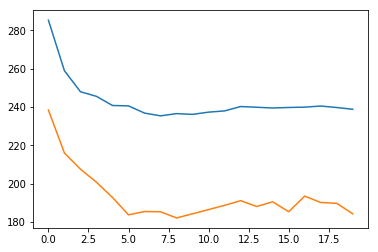

In [2]:
plt.plot(ext("train", "x_loss"))
plt.plot(ext("test", "x_loss"))
plt.show()

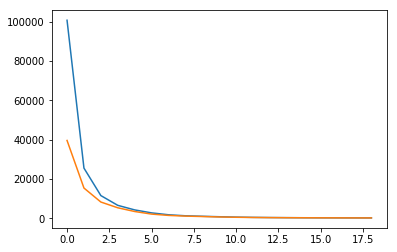

In [3]:
plt.plot(ext("train", "s_loss")[1:])
plt.plot(ext("test", "s_loss")[1:])
plt.show()

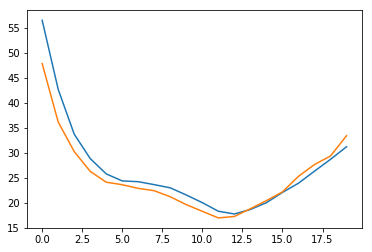

In [4]:
plt.plot(ext("train", "s_aux_loss"))
plt.plot(ext("test", "s_aux_loss"))
plt.show()

In [1]:
import sys
sys.path.append("../")
from config import get_args
from model import SSM
from torch_utils import load_model

import os
import joblib

args = get_args(jupyter=True, args="\
                --device 0 \
                --data_dir ../../data/random \
                --timestamp Jan31_15-10-46 \
                --load_epoch 500")
model = SSM(args)
load_model(model, model_dir="../", epoch=args.load_epoch)

a_mean, a_std, o_mean, o_std = \
    joblib.load(os.path.join(args.data_dir, "param.pkl"))

In [5]:
import gym
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt


env_name = 'HalfCheetah-v2'
env = gym.make(env_name)

true = []
pred = []

o = env.reset()

o = o.astype(np.float32)
o = (o - o_mean) / o_std
o = torch.from_numpy(np.array([o]))
y = model.reset(o)

for _ in range(30):
    # env.render()
    a = env.action_space.sample()
    o, r, done, info = env.step(a)

    a = a.astype(np.float32)
    a = (a - a_mean) / a_std
    a = torch.from_numpy(np.array([a]))
    y = model.step(a)[0]
    y = y.cpu().detach().numpy()
    y = y * o_std + o_mean

    true.append(o)
    pred.append(y)

env.close()

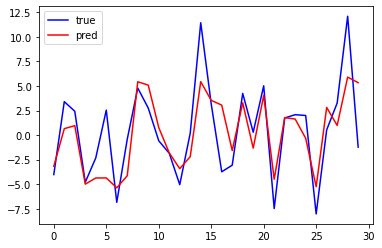

In [6]:
k = -1
plt.plot(np.array(true)[:,k], c='b', label='true')
plt.plot(np.array(pred)[:,k], c='r', label='pred')
plt.legend()
plt.show()

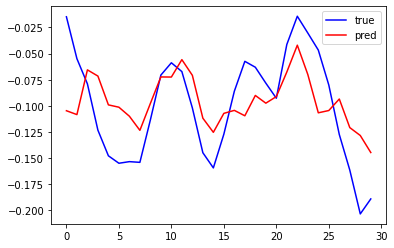

In [7]:
k = 0
plt.plot(np.array(true)[:,k], c='b', label='true')
plt.plot(np.array(pred)[:,k], c='r', label='pred')
plt.legend()
plt.show()